In [58]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [59]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [60]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [61]:
import random
random.seed(42)
random.shuffle(words)

In [62]:
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [63]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [64]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
  

class Embedding:
  def __init__(self, num_embeddings, embedding_dim) -> None:
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, x):
    self.out = self.weight[x]
    return self.out

  def parameters(self):
    return [self.weight]
  
class FlattenConsecutive:
  def __init__(self, n) -> None:
    self.n = n
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  def parameters(self):
    return []
  

class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [65]:
torch.manual_seed(42);

In [73]:
n_embd = 10
n_hidden = 64

model  = Sequential([
    Embedding(vocab_size, n_embd), # takes integer array of shape (batch_size, block_size) and produces (batch_size, block_size, n_embd)
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

20073


In [74]:
ix = torch.randint(0, Xtr.shape[0], (4,))
xb, yb = Xtr[ix], Ytr[ix] 
logits = model(xb)
print(xb.shape)
xb

torch.Size([4, 8])


tensor([[22,  1, 14,  7,  5, 12, 25, 14],
        [ 0,  0, 10, 15, 22,  1, 14, 14],
        [ 0,  0,  0,  0, 11,  1, 13, 19],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [75]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 64)
BatchNorm1d : (4, 4, 64)
Tanh : (4, 4, 64)
FlattenConsecutive : (4, 2, 128)
Linear : (4, 2, 64)
BatchNorm1d : (4, 2, 64)
Tanh : (4, 2, 64)
FlattenConsecutive : (4, 128)
Linear : (4, 64)
BatchNorm1d : (4, 64)
Tanh : (4, 64)
Linear : (4, 27)


In [76]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] 

    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    lossi.append(loss.log10().item())

    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 150000 else 0.01 if i < 180000 else 0.001
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f} ({lr})')
        


      0/ 200000: 3.4087 (0.1)
  10000/ 200000: 2.1505 (0.1)
  20000/ 200000: 1.8094 (0.1)
  30000/ 200000: 2.3393 (0.1)
  40000/ 200000: 2.2732 (0.1)
  50000/ 200000: 2.6675 (0.1)
  60000/ 200000: 2.0343 (0.1)
  70000/ 200000: 1.9814 (0.1)
  80000/ 200000: 1.6954 (0.1)
  90000/ 200000: 1.9406 (0.1)
 100000/ 200000: 1.9787 (0.1)
 110000/ 200000: 1.8358 (0.1)
 120000/ 200000: 2.2373 (0.1)
 130000/ 200000: 2.0021 (0.1)
 140000/ 200000: 1.9165 (0.1)
 150000/ 200000: 2.0140 (0.01)
 160000/ 200000: 2.6815 (0.01)
 170000/ 200000: 1.8279 (0.01)
 180000/ 200000: 1.9237 (0.001)
 190000/ 200000: 2.5280 (0.001)


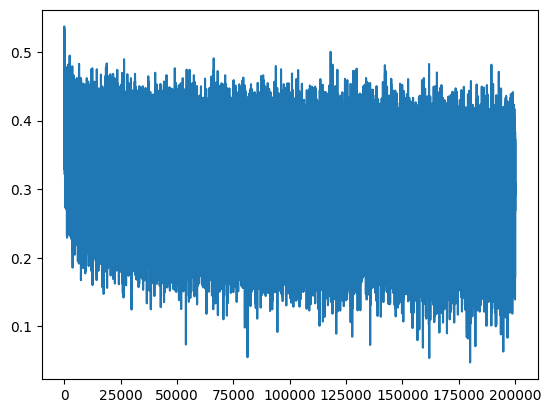

In [77]:
plt.plot(lossi)

In [78]:
for layer in model.layers:
    layer.training = False

In [79]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item():.4f}')

split_loss('train')
split_loss('dev')
split_loss('test')

train loss: 1.9196
dev loss: 2.0178
test loss: 2.0155


In [80]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        x = torch.tensor([context])
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

jammir.
jean.
haael.
jamela.
marynelle.
lenya.
nehman.
rudey.
jabathiros.
aleney.
lunn.
khymley.
jacie.
ieldna.
geyona.
menta.
amery.
abera.
khylen.
karsuz.


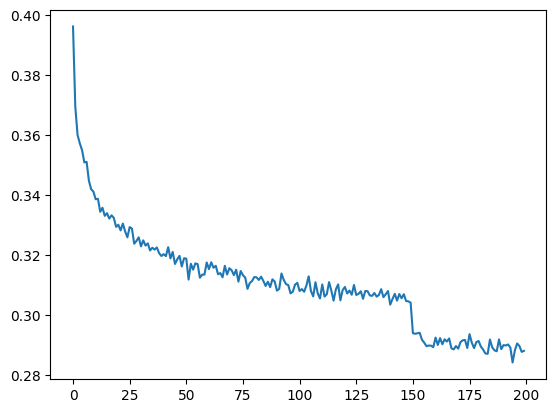

In [ ]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))